# Features Importance

In [1]:
# Import libraries
import os
import sys

# Allow imports from src folder
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)

from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from dateutil import tz
from pandas.tseries.offsets import MonthEnd
from sklearn.preprocessing import MinMaxScaler
import itertools

import math
import numpy as np
import pandas as pd
import fasttrack as ft

from dotenv import load_dotenv
load_dotenv()

True

### Note - FastTrack API key
If you follow [README instructions](../README.md) to run this notebook locally, you should have configured a `.env` file with your FastTrack API key.
Otherwise you can set your API key below.

In [2]:
# Validate FastTrack API connection
api_key = os.getenv('FAST_TRACK_API_KEY', '<REPLACE WITH YOUR KEY>')
client = ft.Fasttrack(api_key)
track_codes = client.listTracks()

Valid Security Key


## 1. Download historic greyhound data from FastTrack API

In [3]:
# Import race data excluding NZ races
au_tracks_filter = list(track_codes[track_codes['state'] != 'NZ']['track_code'])

# Time window to import data
# First day of the month 46 months back from now
date_from = (datetime.today() - relativedelta(months=46)).replace(day=1).strftime('%Y-%m-%d')
# First day of previous month
date_to = (datetime.today() - relativedelta(months=1)).replace(day=1).strftime('%Y-%m-%d')

# Dataframes to populate data with
race_details = pd.DataFrame()
dog_results = pd.DataFrame()

# For each month, either fetch data from API or use local CSV file if we already have downloaded it
for start in pd.date_range(date_from, date_to, freq='MS'):
    start_date = start.strftime("%Y-%m-%d")
    end_date = (start + MonthEnd(1)).strftime("%Y-%m-%d")
    try:
        filename_races = f'FT_AU_RACES_{start_date}.csv'
        filename_dogs = f'FT_AU_DOGS_{start_date}.csv'

        filepath_races = f'../data/{filename_races}'
        filepath_dogs = f'../data/{filename_dogs}'

        print(f'Loading data from {start_date} to {end_date}')
        if os.path.isfile(filepath_races):
            # Load local CSV file
            month_race_details = pd.read_csv(filepath_races) 
            month_dog_results = pd.read_csv(filepath_dogs) 
        else:
            # Fetch data from API
            month_race_details, month_dog_results = client.getRaceResults(start_date, end_date, au_tracks_filter)
            month_race_details.to_csv(filepath_races, index=False)
            month_dog_results.to_csv(filepath_dogs, index=False)

        # Combine monthly data
        race_details = race_details.append(month_race_details, ignore_index=True)
        dog_results = dog_results.append(month_dog_results, ignore_index=True)
    except:
        print(f'Could not load data from {start_date} to {end_date}')

Loading data from 2017-12-01 to 2017-12-31
Loading data from 2018-01-01 to 2018-01-31
Loading data from 2018-02-01 to 2018-02-28
Loading data from 2018-03-01 to 2018-03-31
Loading data from 2018-04-01 to 2018-04-30
Loading data from 2018-05-01 to 2018-05-31


/home/bruno/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Loading data from 2018-06-01 to 2018-06-30
Loading data from 2018-07-01 to 2018-07-31
Loading data from 2018-08-01 to 2018-08-31
Loading data from 2018-09-01 to 2018-09-30
Loading data from 2018-10-01 to 2018-10-31
Loading data from 2018-11-01 to 2018-11-30
Loading data from 2018-12-01 to 2018-12-31
Loading data from 2019-01-01 to 2019-01-31
Loading data from 2019-02-01 to 2019-02-28
Loading data from 2019-03-01 to 2019-03-31
Loading data from 2019-04-01 to 2019-04-30
Loading data from 2019-05-01 to 2019-05-31
Loading data from 2019-06-01 to 2019-06-30
Loading data from 2019-07-01 to 2019-07-31
Loading data from 2019-08-01 to 2019-08-31
Loading data from 2019-09-01 to 2019-09-30
Loading data from 2019-10-01 to 2019-10-31
Loading data from 2019-11-01 to 2019-11-30
Loading data from 2019-12-01 to 2019-12-31
Loading data from 2020-01-01 to 2020-01-31
Loading data from 2020-02-01 to 2020-02-29
Loading data from 2020-03-01 to 2020-03-31
Loading data from 2020-04-01 to 2020-04-30
Loading dat

/home/bruno/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (10,12) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Loading data from 2021-06-01 to 2021-06-30
Loading data from 2021-07-01 to 2021-07-31
Loading data from 2021-08-01 to 2021-08-31
Loading data from 2021-09-01 to 2021-09-30


## 2. Cleanse and normalise the data

In [4]:
# Clean up the race dataset
race_details = race_details.rename(columns = {'@id': 'FastTrack_RaceId'})
race_details['Distance'] = race_details['Distance'].apply(lambda x: int(x.replace("m", "")))
race_details['date_dt'] = pd.to_datetime(race_details['date'], format = '%d %b %y')

In [5]:
# Clean up the dogs results dataset
dog_results = dog_results.rename(columns = {'@id': 'FastTrack_DogId', 'RaceId': 'FastTrack_RaceId'})

# Combine dogs results with race attributes
dog_results = dog_results.merge(
    race_details[['FastTrack_RaceId', 'Distance', 'RaceGrade', 'Track', 'date_dt']], 
    how = 'left',
    on = 'FastTrack_RaceId'
)

# Convert StartPrice to probability
dog_results['StartPrice'] = dog_results['StartPrice'].apply(lambda x: None if x is None else float(x.replace('$', '').replace('F', '')) if isinstance(x, str) else x)
dog_results['StartPrice_probability'] = (1 / dog_results['StartPrice']).fillna(0)
dog_results['StartPrice_probability'] = dog_results.groupby('FastTrack_RaceId')['StartPrice_probability'].apply(lambda x: x / x.sum())

# Discard entries without results (scratched or did not finish)
dog_results = dog_results[~dog_results['Box'].isnull()]
dog_results['Box'] = dog_results['Box'].astype(int)

# Clean up other attributes
dog_results['RunTime'] = dog_results['RunTime'].astype(float)
dog_results['SplitMargin'] = dog_results['SplitMargin'].astype(float)
dog_results['Prizemoney'] = dog_results['Prizemoney'].astype(float).fillna(0)
dog_results['Place'] = pd.to_numeric(dog_results['Place'].apply(lambda x: x.replace("=", "") if isinstance(x, str) else 0), errors='coerce').fillna(0)
dog_results['win'] = dog_results['Place'].apply(lambda x: 1 if x == 1 else 0)

In [6]:
# Normalise some of the raw values
dog_results['Prizemoney_norm'] = np.log10(dog_results['Prizemoney'] + 1) / 12
dog_results['Place_inv'] = (1 / dog_results['Place']).fillna(0)
dog_results['Place_log'] = np.log10(dog_results['Place'] + 1).fillna(0)
dog_results['RunSpeed'] = (dog_results['RunTime'] / dog_results['Distance']).fillna(0)

## 3. Generate features using raw data

In [7]:
# Calculate median winner time per track/distance
win_results = dog_results[dog_results['win'] == 1]
median_win_time = pd.DataFrame(data=win_results[win_results['RunTime'] > 0].groupby(['Track', 'Distance'])['RunTime'].median()).rename(columns={"RunTime": "RunTime_median"}).reset_index()
median_win_split_time = pd.DataFrame(data=win_results[win_results['SplitMargin'] > 0].groupby(['Track', 'Distance'])['SplitMargin'].median()).rename(columns={"SplitMargin": "SplitMargin_median"}).reset_index()

In [8]:
# Calculate track speed index
median_win_time['speed_index'] = (median_win_time['RunTime_median'] / median_win_time['Distance'])
median_win_time['speed_index'] = MinMaxScaler().fit_transform(median_win_time[['speed_index']])

In [9]:
# Compare dogs finish time with median winner time
dog_results = dog_results.merge(median_win_time, on=['Track', 'Distance'], how='left')
dog_results = dog_results.merge(median_win_split_time, on=['Track', 'Distance'], how='left')

# Normalise time comparison
dog_results['RunTime_norm'] = (dog_results['RunTime_median'] / dog_results['RunTime']).clip(0.9, 1.1)
dog_results['RunTime_norm'] = MinMaxScaler().fit_transform(dog_results[['RunTime_norm']])
dog_results['SplitMargin_norm'] = (dog_results['SplitMargin_median'] / dog_results['SplitMargin']).clip(0.9, 1.1)
dog_results['SplitMargin_norm'] = MinMaxScaler().fit_transform(dog_results[['SplitMargin_norm']])

In [10]:
# Calculate box winning percentage for each track/distance
box_win_percent = pd.DataFrame(data=dog_results.groupby(['Track', 'Distance', 'Box'])['win'].mean()).rename(columns={"win": "box_win_percent"}).reset_index()
# Add to dog results dataframe
dog_results = dog_results.merge(box_win_percent, on=['Track', 'Distance', 'Box'], how='left')

In [11]:
# Generate rolling window features
dataset = dog_results.copy()
dataset = dataset.set_index(['FastTrack_DogId', 'date_dt']).sort_index()

# Use rolling window of 28, 91 and 365 days
rolling_windows = ['28D', '91D', '365D']
# Features to use for rolling windows calculation
features = ['RunTime_norm', 'SplitMargin_norm', 'Place_inv', 'Place_log', 'Prizemoney_norm']
# Aggregation functions to apply
aggregates = ['min', 'max', 'mean', 'median', 'std']
# Keep track of generated feature names
feature_cols = ['speed_index', 'box_win_percent']

for rolling_window in rolling_windows:
        print(f'Processing rolling window {rolling_window}')

        rolling_result = (
            dataset
            .reset_index(level=0)
            .groupby('FastTrack_DogId')[features]
            .rolling(rolling_window)
            .agg(aggregates)
            .shift(1)
        )

        # Generate list of rolling window feature names (eg: RunTime_norm_min_365D)
        agg_features_cols = [f'{f}_{a}_{rolling_window}' for f, a in itertools.product(features, aggregates)]
        # Add features to dataset
        dataset[agg_features_cols] = rolling_result
        # Keep track of generated feature names
        feature_cols.extend(agg_features_cols)

Processing rolling window 28D
Processing rolling window 91D
Processing rolling window 365D


In [12]:
# Replace missing values with 0
dataset.fillna(0, inplace=True)

## 4. Train Models

In [13]:
# Only keep data after 2018-12-01
model_df = dataset.reset_index()
feature_cols = np.unique(feature_cols).tolist()
model_df = model_df[model_df['date_dt'] >= '2018-12-01']
model_df = model_df[['date_dt', 'FastTrack_RaceId', 'DogName', 'win', 'StartPrice_probability'] + feature_cols]

# Only train model off of races where each dog has a value for each feature
races_exclude = model_df[model_df.isnull().any(axis = 1)]['FastTrack_RaceId'].drop_duplicates()
model_df = model_df[~model_df['FastTrack_RaceId'].isin(races_exclude)]

# Split the data into train and test data
train_data = model_df[model_df['date_dt'] < '2021-01-01'].reset_index(drop = True).sample(frac=1)
test_data = model_df[model_df['date_dt'] >= '2021-01-01'].reset_index(drop = True)

train_x, train_y = train_data[feature_cols], train_data['win']
test_x, test_y = test_data[feature_cols], test_data['win']

In [14]:
from matplotlib import pyplot
from matplotlib.pyplot import figure

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

# Gradient Boosting Machines libraries
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Common models parameters
verbose       = 0
learning_rate = 0.1
n_estimators  = 100

# Train different types of models
models = {
    'LogisticRegression':         LogisticRegression(verbose=0, solver='saga', n_jobs=-1),
    'GradientBoostingClassifier': GradientBoostingClassifier(verbose=verbose, learning_rate=learning_rate, n_estimators=n_estimators, max_depth=3, max_features=0.25),
    'RandomForestClassifier':     RandomForestClassifier(verbose=verbose, n_estimators=n_estimators, max_depth=8, max_features=0.5, n_jobs=-1),
    'LGBMClassifier':             LGBMClassifier(verbose=verbose, learning_rate=learning_rate, n_estimators=n_estimators, force_col_wise=True),
    'XGBClassifier':              XGBClassifier(verbosity=verbose, learning_rate=learning_rate, n_estimators=n_estimators, objective='binary:logistic', use_label_encoder=False),
    'CatBoostClassifier':         CatBoostClassifier(verbose=verbose, learning_rate=learning_rate, n_estimators=n_estimators)
}

print(f'Training on {len(train_x):,} samples with {len(feature_cols)} features')
for key, model in models.items():
    print(f'Fitting model {key}')
    model.fit(train_x, train_y)

Training on 630,306 samples with 77 features
Fitting model LogisticRegression
Fitting model GradientBoostingClassifier
Fitting model RandomForestClassifier
Fitting model LGBMClassifier
Fitting model XGBClassifier
Fitting model CatBoostClassifier


## 5. Display models features importance

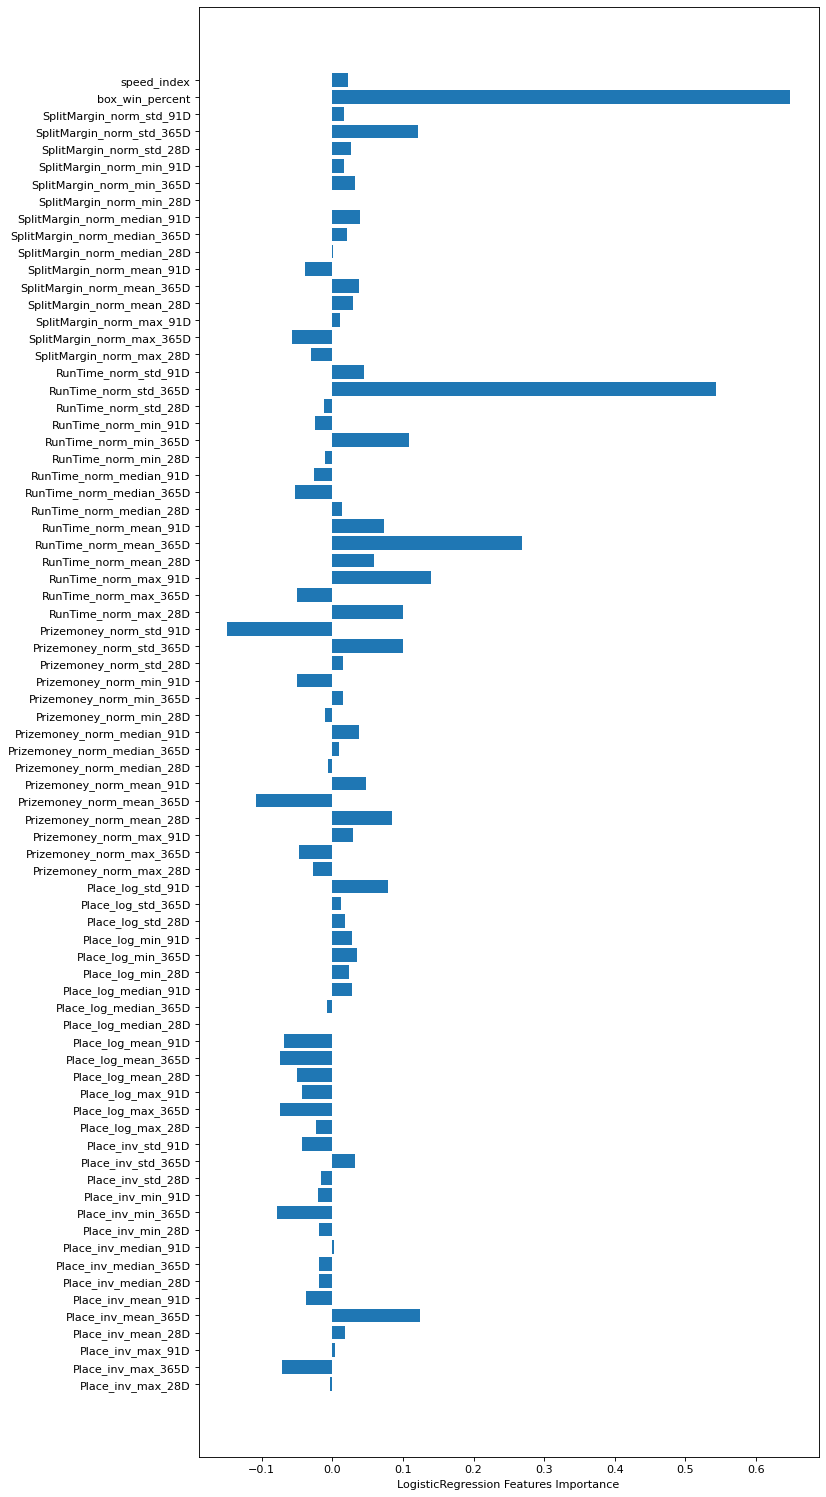

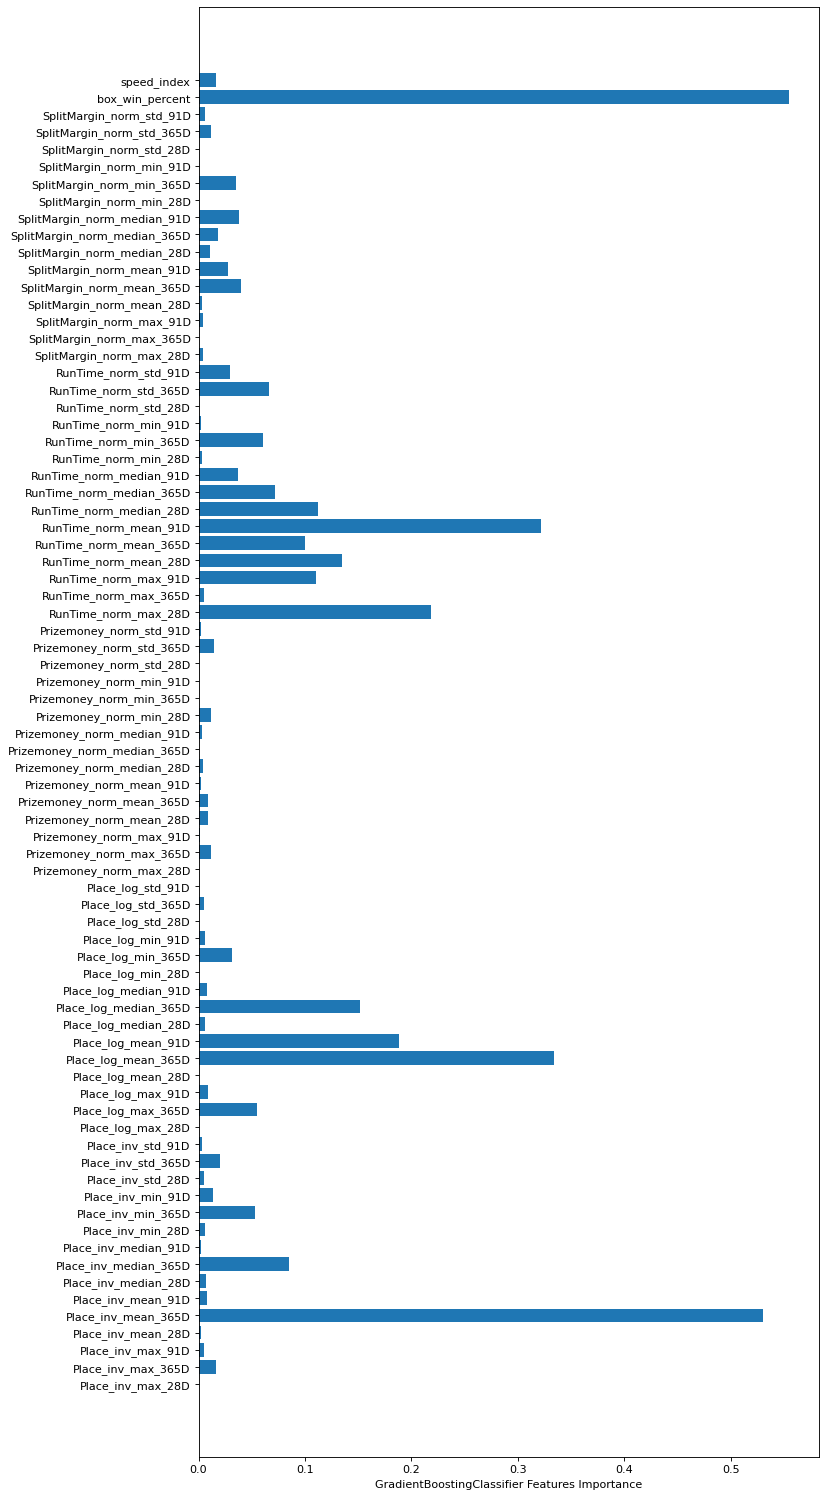

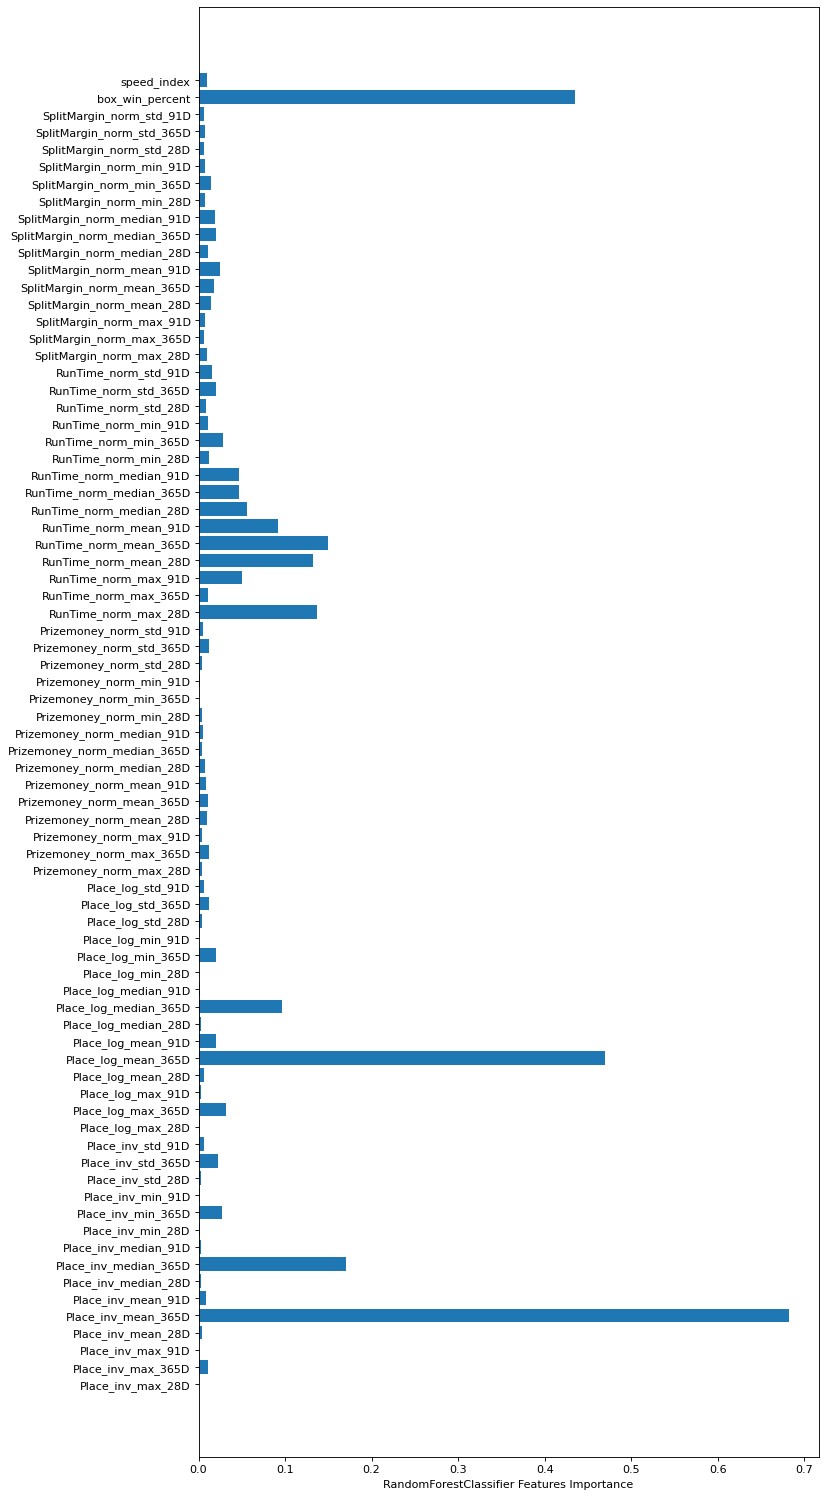

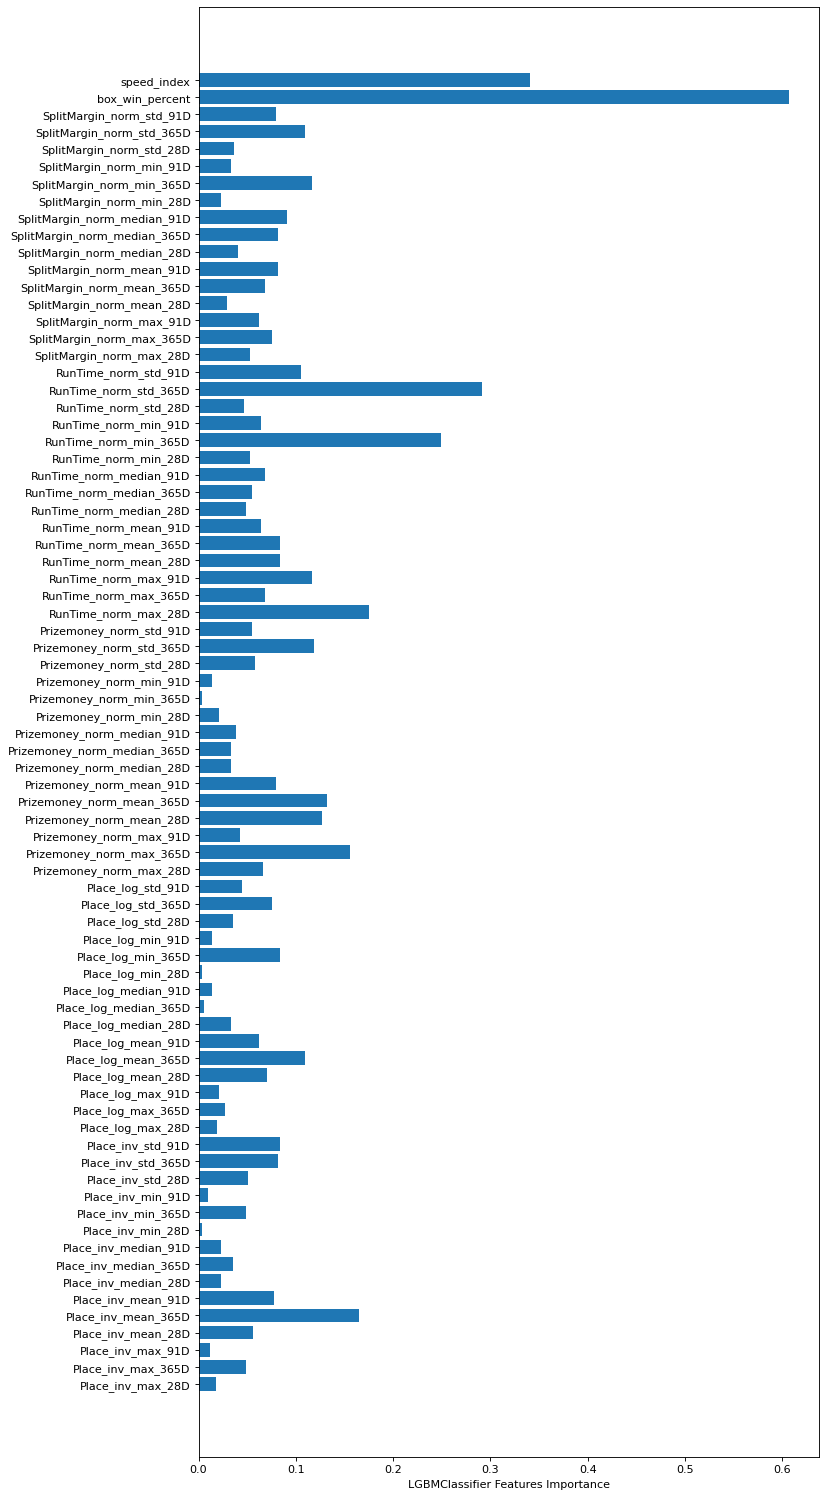

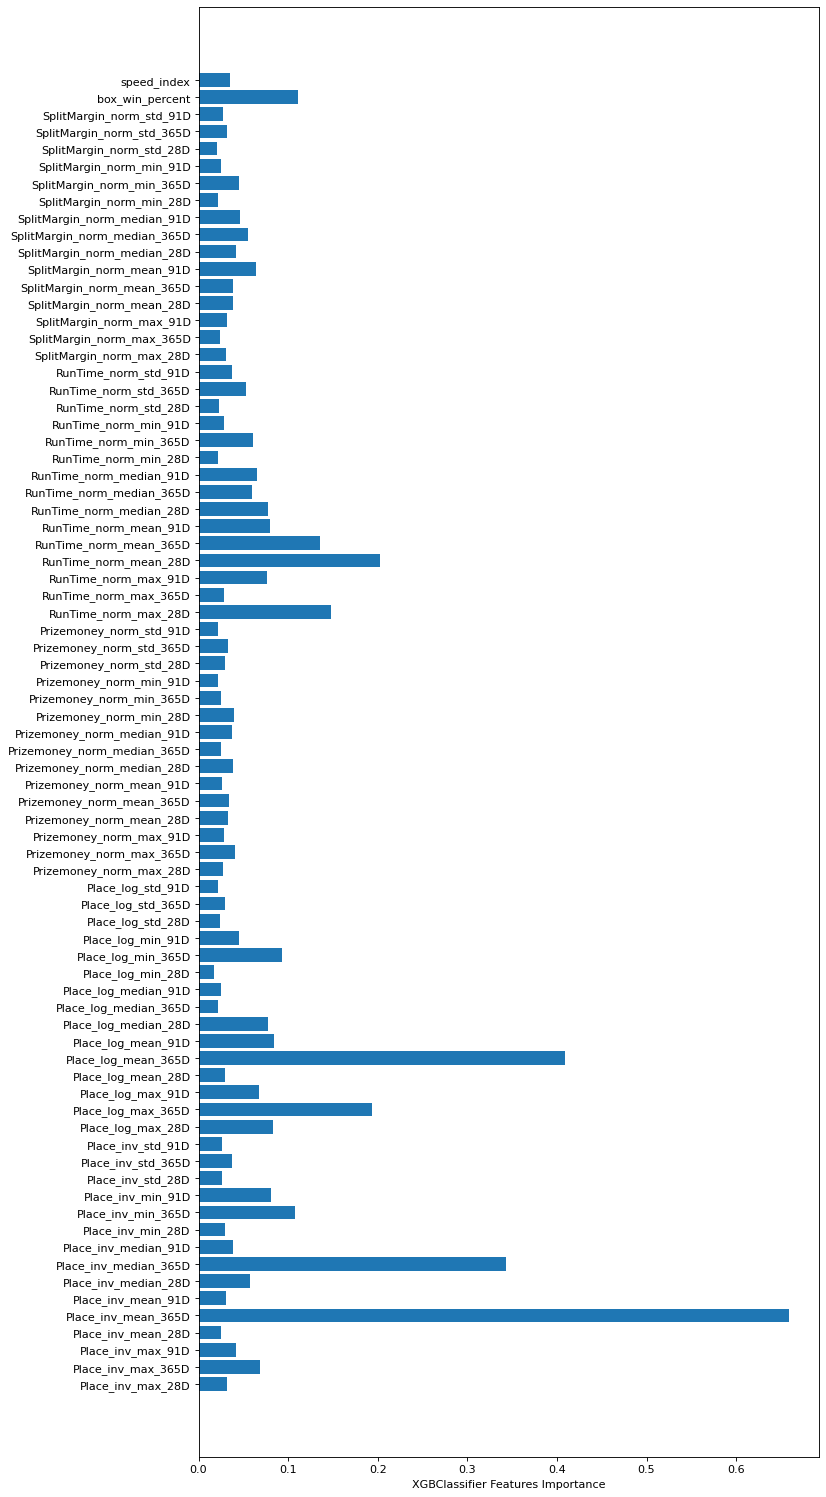

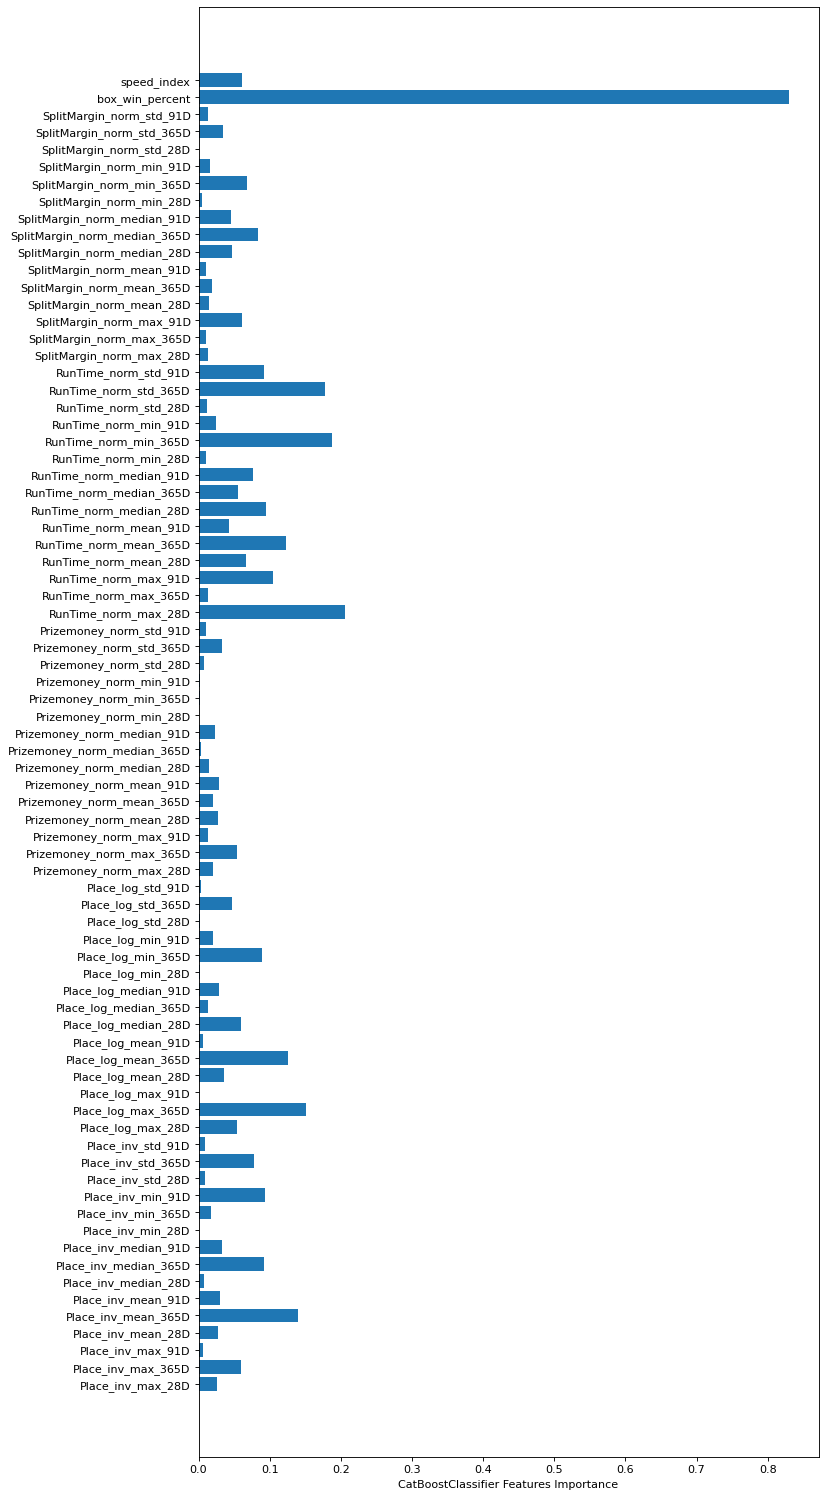

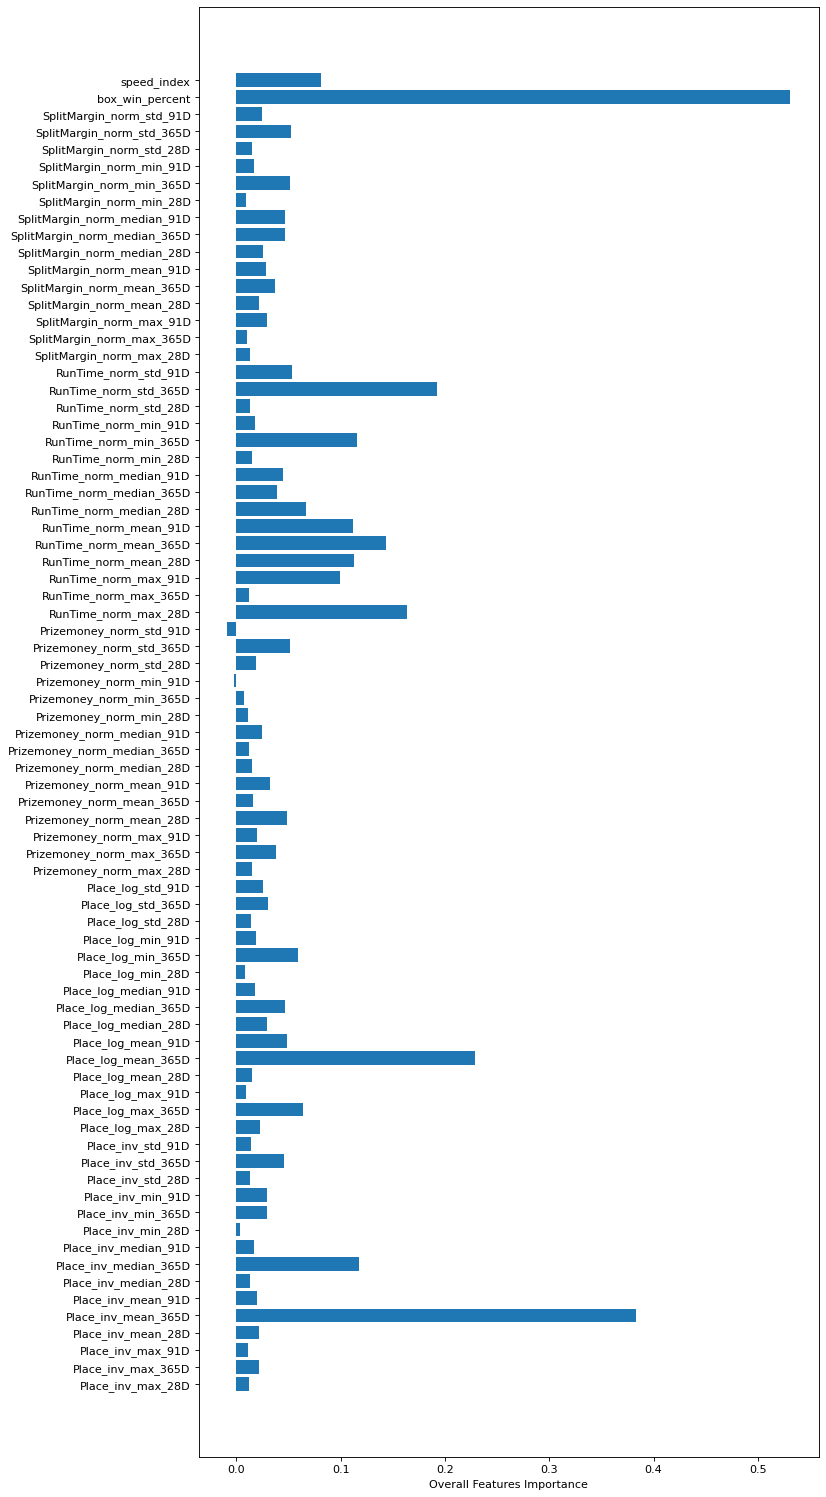

In [15]:
from sklearn.preprocessing import normalize

total_feature_importances = []

# Individual models feature importance
for key, model in models.items():
    figure(figsize=(10, 24), dpi=80)
    if isinstance(model, LogisticRegression):
        feature_importance = model.coef_[0]
    else:
        feature_importance = model.feature_importances_
    
    feature_importance = normalize(feature_importance[:,np.newaxis], axis=0).ravel()
    total_feature_importances.append(feature_importance)
    pyplot.barh(feature_cols, feature_importance)
    pyplot.xlabel(f'{key} Features Importance')
    pyplot.show()

# Overall feature importance
avg_feature_importances = np.asarray(total_feature_importances).mean(axis=0)
figure(figsize=(10, 24), dpi=80)
pyplot.barh(feature_cols, avg_feature_importances)
pyplot.xlabel('Overall Features Importance')
pyplot.show()